# EDA

In [8]:
import numpy as np
import pandas as pd
from pulp import * 

In [16]:
sampleData = pd.read_csv('nutritionalValues.csv').drop(columns = 'VegNovVeg', axis=1)
sampleData.head()

,Food_items,Breakfast,Lunch,Dinner,Calories,Fats,Proteins,Iron,Calcium,Sodium,Potassium,Carbohydrates,Fibre,VitaminD,Sugars
0,aloo Tikki,0,1,1,22,0.2,2.4,0.91,23.0,14,224.0,4.1,2.0,0,1.3
1,Kadhi,1,0,0,160,15.0,2.0,0.55,12.0,7,485.0,8.5,6.7,0,0.7
2,Bananas,1,0,0,89,0.3,1.1,0.26,5.0,1,358.0,23.0,2.6,0,12.0
3,Bread made in wheat,0,1,1,250,1.5,10.0,2.76,20.0,439,165.0,49.0,4.1,0,6.1
4,Mango Chutney,1,0,0,349,0.4,14.0,6.80,190.0,298,77.0,77.0,13.0,0,46.0


In [17]:
sampleData.shape

(7895, 15)

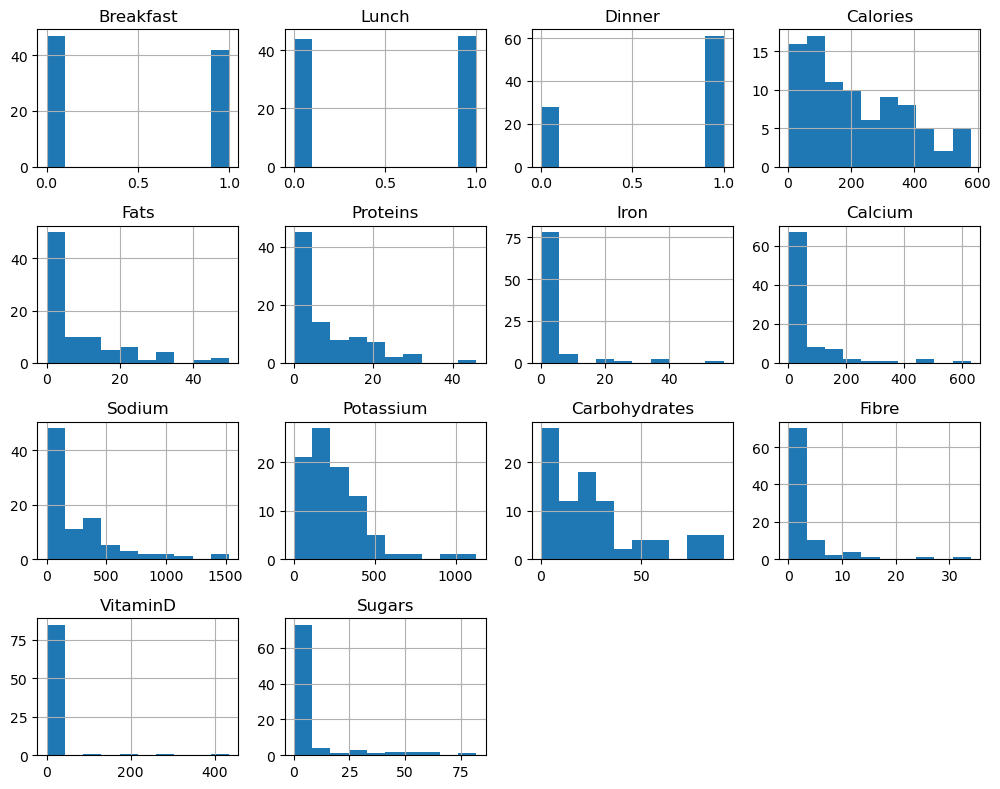

In [13]:
sampleData.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

In [ ]:
sampleData.skew()

In [8]:
optcols = ['Food_items', 'Calories', 'Fats', 'Proteins','Carbohydrates']
opt = sampleData[optcols]
#converting fats, proteins and carbs columns to float-type
flt = ['Fats', 'Proteins','Carbohydrates']
opt[flt].astype(float)

,Fats,Proteins,Carbohydrates
0,0.2,2.4,4.1
1,15.0,2.0,8.5
2,0.3,1.1,23.0
3,1.5,10.0,49.0
4,0.4,14.0,77.0
...,...,...,...
84,11.0,3.5,24.0
85,8.4,3.2,28.0
86,0.2,1.8,81.0
87,30.0,7.7,59.0


# Data Splitting

In [10]:
X=sampleData[['Calories', 'Fats', 'Proteins','Carbohydrates']]
y=sampleData['Food_items']

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state= 99)

# Random Forest

In [5]:
models = []
accuracies=[]

In [3]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(criterion = 'gini', max_depth = 8, min_samples_split = 10, random_state = 5)
clf.fit(X_train,y_train)
clf.feature_importances_
y_pred = clf.predict(X_test)

In [2]:
from sklearn.metrics import accuracy_score
x= accuracy_score(y_test, y_pred)
accuracies.append(x)
models.append('Random Forest')
print(x*100)

82.10116731517509


# Optimization 

In [4]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

#now, we split the data randomly into 8 equal parts
splitValuesDays = np.linspace(0,len(opt),8).astype(int)

#we divided the data into 8 equal parts, because the dataset may/may not be divisible by 7
#so the following will make sure any data point is not missed
splitValuesDays[-1] = splitValuesDays[-1] - 1

#Now we randomise the food into the days, lets define a function
def randomisedDays():
   fracValues = opt.sample(frac=1).reset_index().drop('index',axis=1)
   dayData = [] #an empty list to be appended with the data of a specific day
   for z in range(len(splitValuesDays)-1):
    dayData.append(fracValues.loc[splitValuesDays[z]:splitValuesDays[z+1]]) #this slices splitValuesDays, and loc is a function to access rows
   return dict(zip(days, dayData))

In [5]:
meals = ['Breakfast', 'Snack 1', 'Lunch', 'Snack 2', 'Dinner']
splitValuesMeal = np.linspace(0,splitValuesDays[1],len(meals)+1).astype(int)
splitValuesMeal[-1] = splitValuesMeal[-1] - 1

import random
def randomisedMeals(dayData):
    mealsData = {}
    for meal in meals:
        fracValues = dayData.sample(frac=1).reset_index(drop=True)
        mealData = fracValues.sample(frac=random.uniform(0.5, 1.0)).reset_index(drop=True)
        mealsData[meal] = mealData
    return mealsData

In [6]:
def nutritional_calories(weight, cals):
  pr_cals = weight*4 #it is assumed that 1 gram of protein gives approx 4 calories
  carb_cals = cals/2
  fat_cals = cals - (pr_cals + carb_cals)
  finalcals = {"Protein calories" : pr_cals , "Carbohydrate calories" : carb_cals, "Fat calories" : fat_cals}
  return finalcals

In [7]:
def nutritional_grams(calsdict):
  pr_grams = calsdict['Protein calories']/4 #approx 4 calories per gram of proteins
  carb_grams = calsdict['Carbohydrate calories']/4 #approx 4 calories per gram of carbohydrates
  fat_grams = calsdict['Fat calories']/9 #approx 9 calories per gram of fats
  finalgrams = {"Protein grams" : pr_grams, "Carbohydrate grams" : carb_grams , "Fat grams" : fat_grams}
  return finalgrams

In [8]:
daysData = randomisedDays()
def dietModel(constr, day, weight, cals, food, data):
  gms = nutritional_grams(nutritional_calories(weight, cals)) #dictionary for grams required for intake
  P = gms['Protein grams']
  F = gms['Fat grams']
  B = gms['Carbohydrate grams']
  dayData = daysData[day]
  dayData = dayData[dayData.Calories !=0] #removes any rows that have calories=0

  meal = dayData.Food_items.tolist() #converts the food_items column to list
  c = dayData.Calories.tolist() #converts the calories column to list
  np.random.shuffle(meal)

  x  = pulp.LpVariable.dicts( "x", indices = meal, lowBound=0, upBound=1.5, cat='Continuous', indexStart=[] )

  p = dayData.Proteins.tolist()
  f = dayData.Fats.tolist()
  b = dayData.Carbohydrates.tolist()

  #using PuLP to optimize
  constr = pulp.LpProblem("DietCalculator", LpMinimize) #creates a new Linear Programming Problem (LPP)
  #objective function:
  constr += pulp.lpSum([x[meal[i]]*c[i] for i in range(len(meal))]) #lpSum adds everything (Σ) and for loop iterates over each food_item
  #constraints:
  splitMeal = {'Snack 1': 0.10, 'Snack 2':0.10,'Breakfast': 0.15,'Lunch':0.35, 'Dinner':0.30}
  divMeal = splitMeal[food]
  constr += pulp.lpSum([x[meal[i]]*p[i] for i in range(len(x))]) >= P*divMeal #constraint for proteins
  constr += pulp.lpSum([x[meal[i]]*f[i] for i in range(len(x))]) >= F*divMeal  #constraint for fats
  constr += pulp.lpSum([x[meal[i]]*b[i] for i in range(len(x))]) >= B*divMeal #constraint for carbohydrates
  #solving the problem using pulp's solving function
  constr.solve()

  #formatting the solution into a dataframe:
  vars, values = [] , []
  for l in constr.variables():
    var = l.name #name of decision variable
    val = l.varValue
    vars.append(var)
    values.append(val)
  values = np.array(values).round(2).astype(float) #array for decision variables, upto 2 decimal places with type float
  #solution into df
  solution = pd.DataFrame(np.array([meal, values]).T, columns = ['Food Items', 'Quantity']) #making df using pandas
  solution['Quantity'] = solution.Quantity.astype(float)
  solution = solution[solution['Quantity'] != 0] #eliminating any items with quantity=0
  solution.Quantity *= 100 #converting into grams
  solution = solution.rename(columns = {'Quantity' : 'Quantity (grams)'})
  return solution

#For the final model implementation
def baseModel(weight, cals):
  result = []
  for day in days:
    constr = pulp.LpProblem("DietCalculator", LpMinimize)
    print(f'Building a model for {day}')
    result.append(dietModel(constr, day, weight, cals))
  return dict(zip(days, result))

In [9]:
#final model that runs dietModel and baseModel respectively
def finalModel(weight, cals):
    res_model = []
    for day in days:
        dayData = daysData[day]
        mealsData = randomisedMeals(dayData)
        mealModel = {}
        for meal in meals:
            constr = pulp.LpProblem("DietCalculator", LpMinimize)
            solModel = dietModel(constr, day, weight, cals, meal, mealsData)

            mealModel[meal] = solModel
        res_model.append(mealModel)
    return dict(zip(days,res_model))

In [16]:
def execModel(diet, selected_days):
    output_list = []
    for day in selected_days:
        meal_labels = []
        for meal in X_train:
            meal_data = diet[day][meal]
            if not meal_data.empty:

                if meal not in meal_labels:
                    meal_data_formatted = meal_data[['Food Items', 'Quantity (grams)']].copy()
                    meal_data_formatted['Food Items'] = meal_data_formatted['Food Items'].apply(lambda x: x.ljust(25))
                    ufo.append(meal_data_formatted)
    return output_List
     

# GNB

In [15]:
from sklearn.naive_bayes import GaussianNB

NaiveBayes = GaussianNB()

NaiveBayes.fit(X_train,y_train)

predicted_values = NaiveBayes.predict(X_test)
x = metrics.accuracy_score(y_test, predicted_values)
models.append('Guassian Naive Bayes')
accuracies.append(x)
print(x)

print(classification_report(y_test,predicted_values))

0.36147858978579
              precision    recall      f1-score    support
0             0.38         0.64            0.8         128
1             0.44         0.91            0.84        129
accuracy                                   0.82        257
macro avg     0.33         0.52            0.82        257
weighted avg  0.29         0.42            0.82        257


# SVM

In [18]:
from sklearn.svm import SVC

from sklearn.preprocessing import MinMaxScaler

norm = MinMaxScaler().fit(X_train)
X_train_norm = norm.transform(X_train)

X_test_norm = norm.transform(X_test)
SVM = SVC(kernel='poly', degree=3, C=1)
SVM.fit(X_train_norm,y_train)
predicted_values = SVM.predict(X_test_norm)
x = metrics.accuracy_score(y_test, predicted_values)

print(x)
models.append('SVM')
accuracies.append(x)
print(classification_report(y_test,predicted_values))

0.6375453212465133
              precision    recall      f1-score    support
0             0.63         0.73            0.8         128
1             0.57         0.91            0.84        129
accuracy                                   0.82        257
macro avg     0.66         0.82            0.82        257
weighted avg  0.58         0.82            0.82        257


# Accuracies Comparison

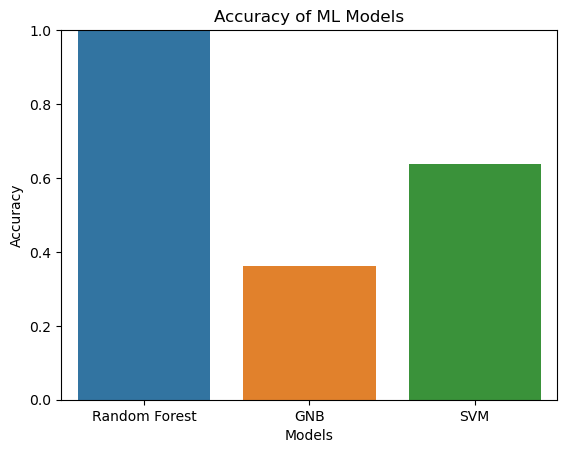

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=models, y=accuracies)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of ML Models')
plt.ylim(0, 1)  # Setting y-axis limit to ensure proper visualization

# Show plot
plt.show()

# Exporting Random Forest

In [ ]:
import pickle
from sklearn.ensemble import RandomForestClassifier

# Export the model using pickle
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)
